<a href="https://colab.research.google.com/github/SarahFSBorges/data.science/blob/main/Detectando_a_Placa_de_um_Carro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 4 - Automatic License/Number Plate Recognition (ANPR)

1. Detectar e localizar a placa a partir de uma imagem ou frame de vídeo
2. Extrair os caracteres da placa
3. Aplicar técnicas de OCR para reconhecer os dígitos exrtaídos.

## Qual é o problema?

* Diferentes ângulos
* Diferentes modelos de placas
* Diferentes modelos de carro
* Movimento do veículo
* Diferença na luminosidade
* Objetos cobrindo parte da placa
* Falta de um dataset brasileiro robusto e abrangente


## Premissas desta aula

* A foto contém exclusivamente 1 carro;
* O padrão de placa será Mercosul, ou seja, letras escuras em um fundo claro.

## Fluxo do Algoritmo

1. Converter a imagem para *grayscale*
2. Black Hat Morphological Transformations 
    * Revelar caracteres escuros contra fundos claros.
    * In mathematical morphology and digital image processing, top-hat transform is an operation that extracts small elements and details from given images. There are two types of top-hat transform — the white top-hat transform and the black top-hat transform. The white top-hat transform can be defined as the difference between the input image and its opening by some structuring element, while the black top-hat transform can be defined as the difference between the closing and the input image. Top-hat transforms can be used for various image processing tasks, such as feature extraction, background equalization, image enhancement, and others.
    * You should note that the size, or width, of the elements that are extracted by top-hat transforms can be controlled by the choice of the structuring element. The bigger the kernel, the larger the elements extracted.
3. Operação de fechamento para preencher gaps e áreas pequenas, a fim de identificar estruturas maiores.
4. Calcular o Gradiente de magnitude (eixo x), considerando a imagem da transformação Black Hat.
    * Colocar o resultado dentro da escala [0, 255]
5. Suavizar a imagem, aplicar uma transformação de fechamento e outro threshold binário usando o método Otsu's.

In [140]:
# importar os nossos pacotes
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import imutils
import numpy as np

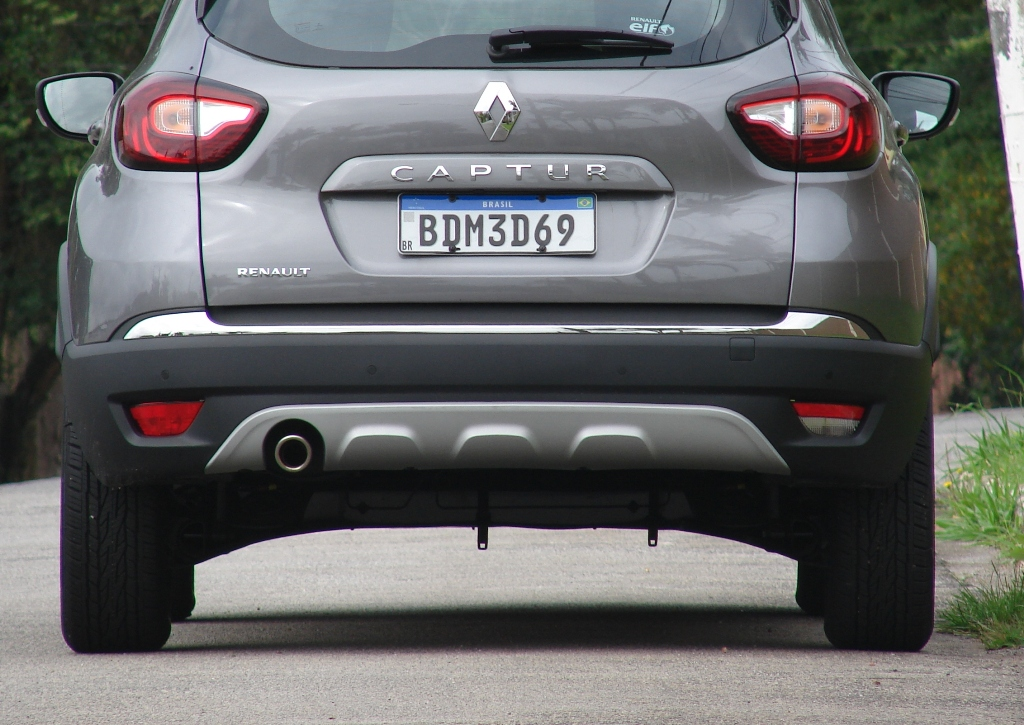

In [190]:
image = cv2.imread("placa.jpg")
cv2_imshow(image)

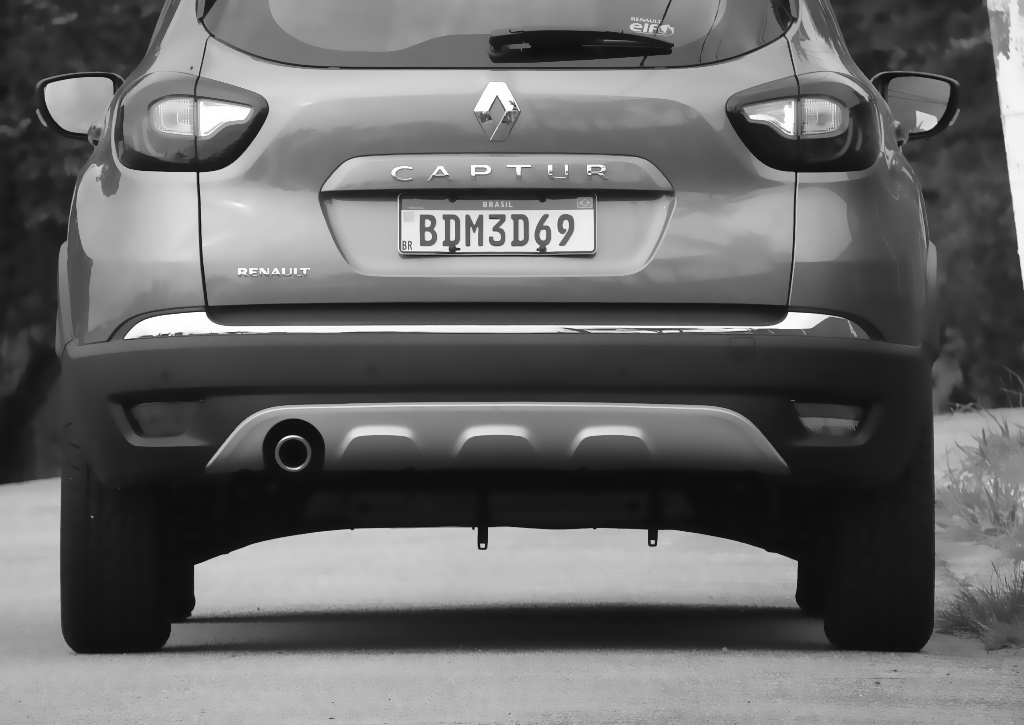

In [191]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 13, 15, 15)

cv2_imshow(gray)

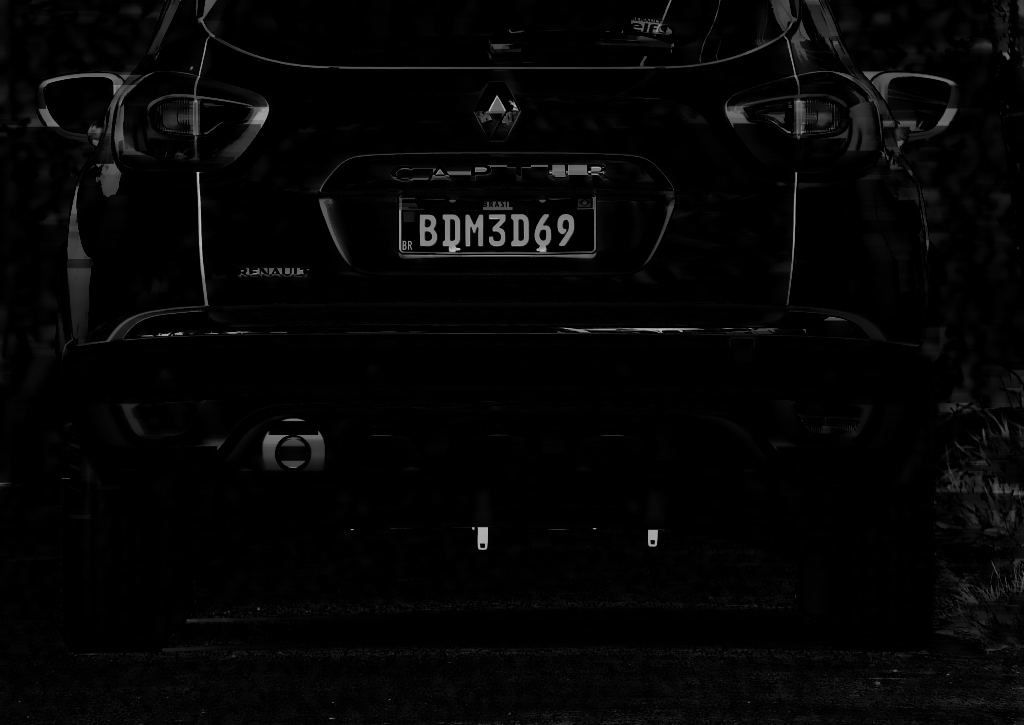

In [192]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5))
black_hat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

cv2_imshow(black_hat)

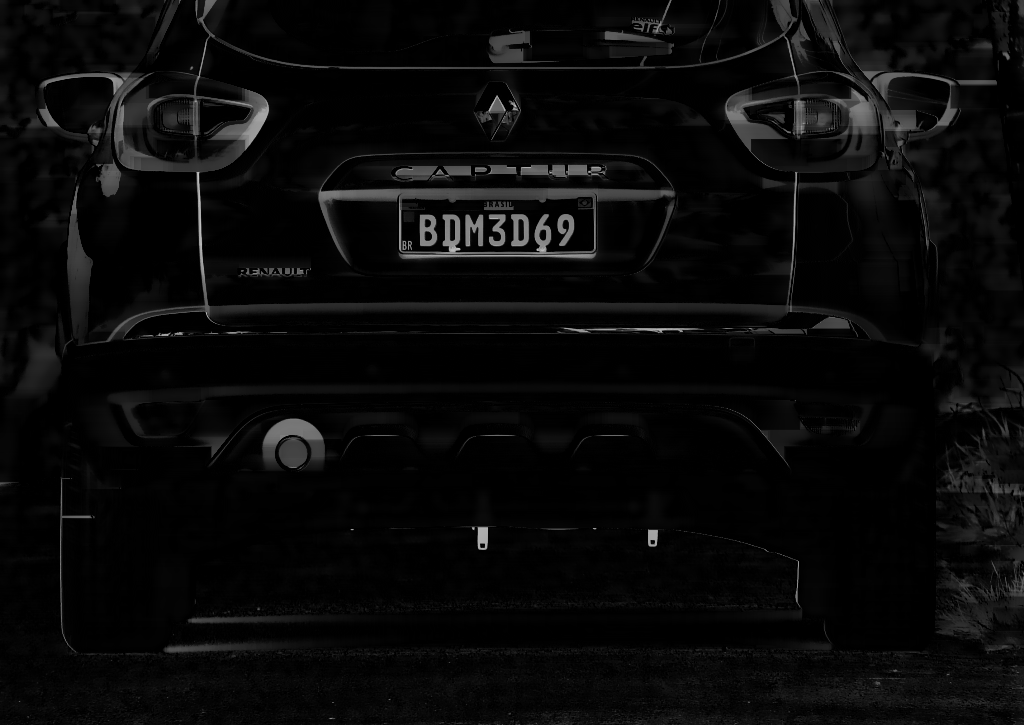

In [193]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 13))
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 3))
black_hat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

cv2_imshow(black_hat)

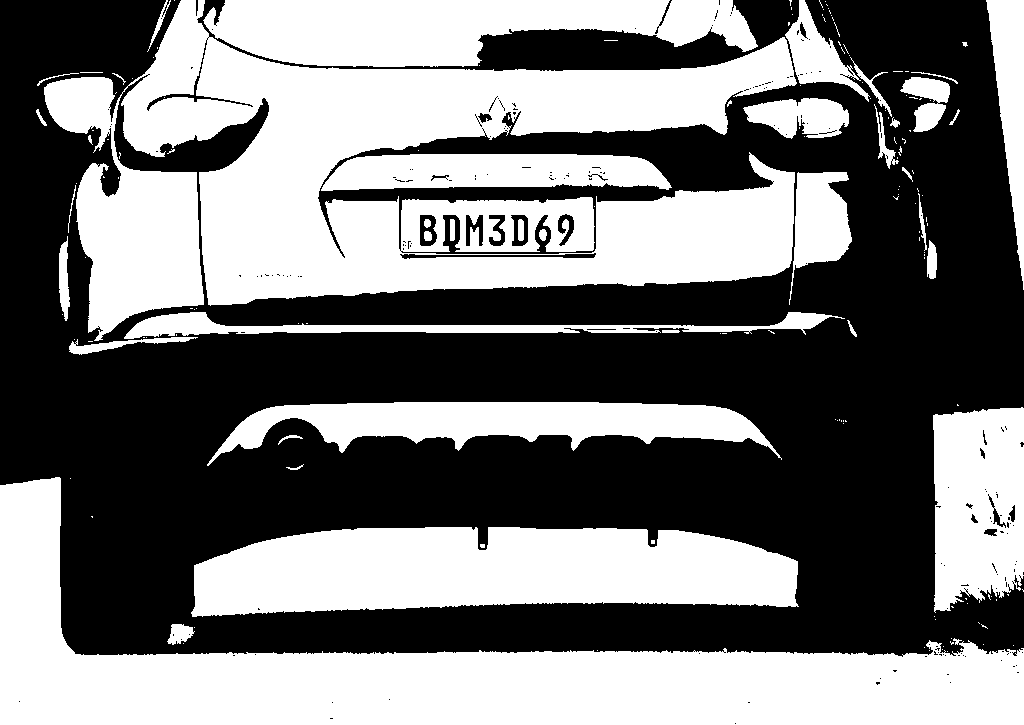

In [194]:
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
luz = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel2)
luz = cv2.threshold(luz, 2, 300, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

cv2_imshow(luz)

Antes:
0.0
3085.0

Depois
0.0
300.0


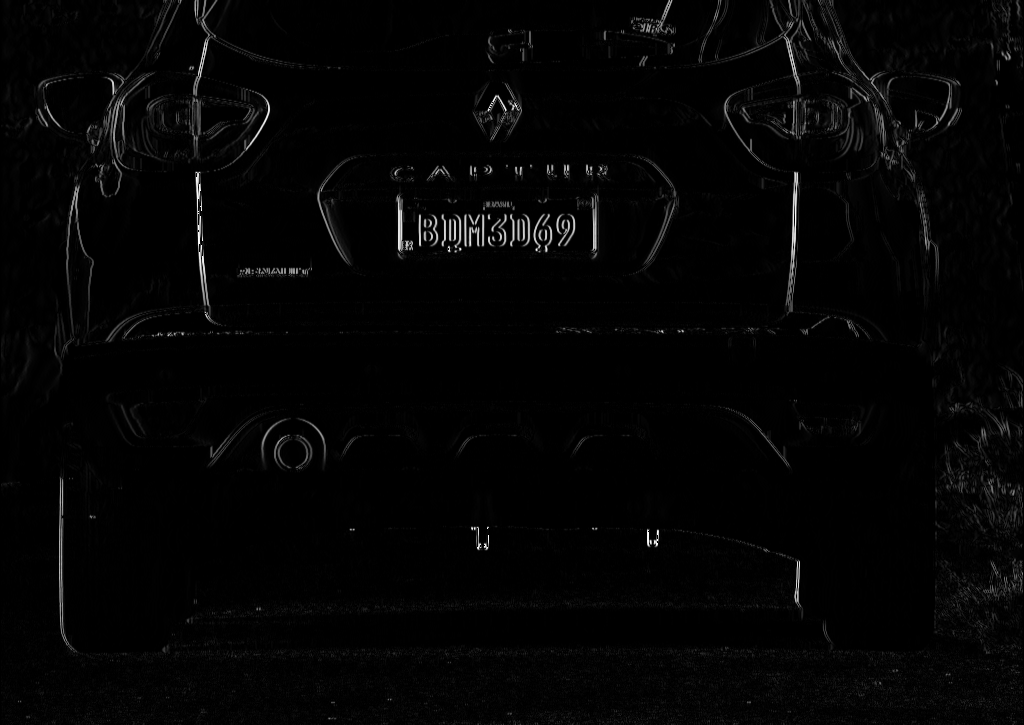

In [195]:
gradient_x = cv2.Sobel(black_hat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-2)
gradient_x = np.absolute(gradient_x)

# valores acima de 255
print("Antes:")
print(np.min(gradient_x))
print(np.max(gradient_x))

# extrair valores minimos e máximos
(minimo, maximo) = (np.min(gradient_x), np.max(gradient_x))

# normalizar (valor - min) / (max - min)
gradient_x = 300 * ((gradient_x - minimo) / (maximo - minimo))

# ver valores minimos e máximos
print("\nDepois")
print(np.min(gradient_x))
print(np.max(gradient_x))

# vamos para UINT8
gradient_x = gradient_x.astype("uint8")

# ver a imagem
cv2_imshow(gradient_x)

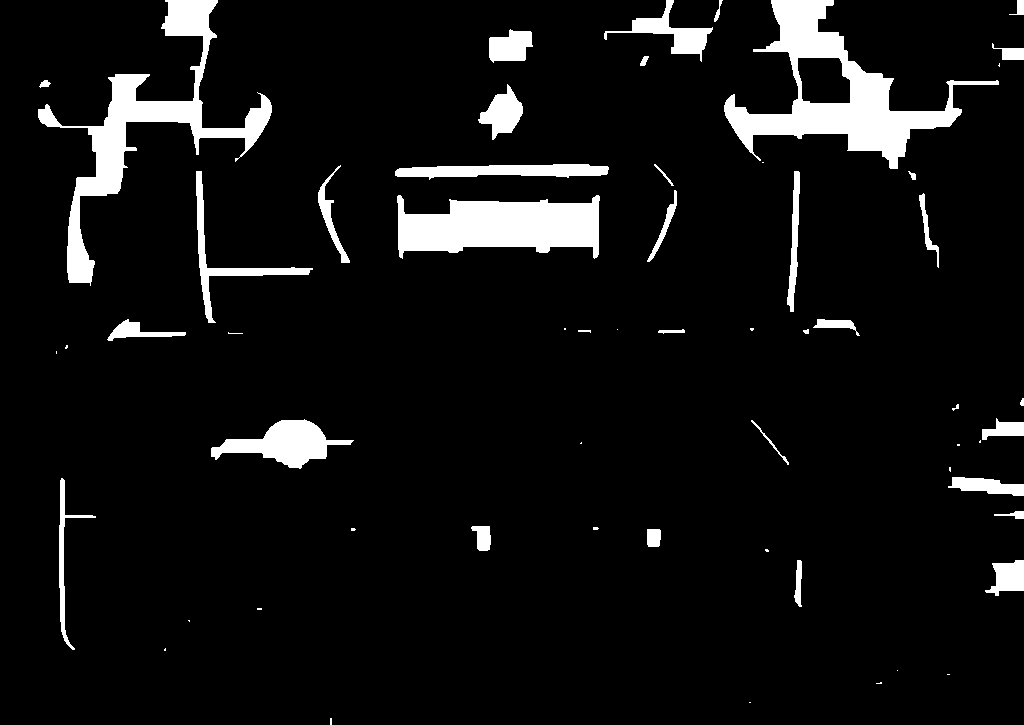

In [196]:
gradient_x = cv2.GaussianBlur(gradient_x, (5, 5), 0)
# cv2_imshow(gradient_x)
gradient_x = cv2.morphologyEx(gradient_x, cv2.MORPH_CLOSE, kernel)
# cv2_imshow(gradient_x)
thres = cv2.threshold(gradient_x, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2_imshow(thres)

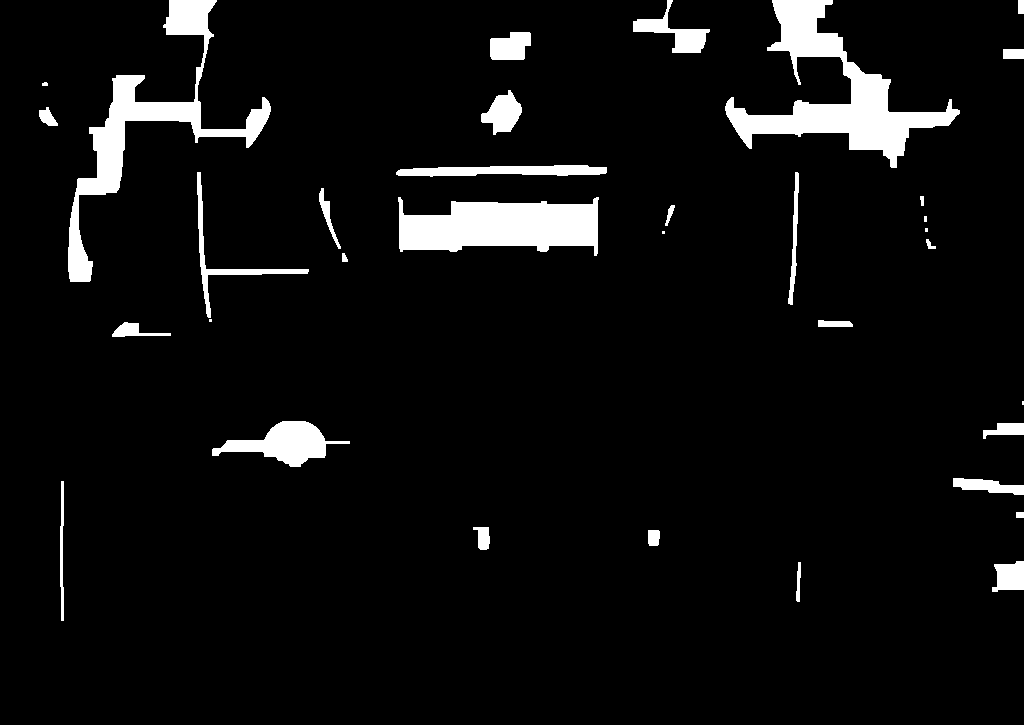

In [197]:
thres = cv2.erode(thres, None, iterations=2)  # 2
thres = cv2.dilate(thres, None, iterations=1) # 1

cv2_imshow(thres)

In [202]:
contornos = cv2.findContours(thres.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contornos = imutils.grab_contours(contornos)
contornos = sorted(contornos, key=cv2.contourArea, reverse=True)[:3]

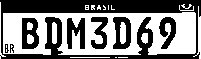

In [203]:
for c in contornos:
    (x, y, w, h) = cv2.boundingRect(c)
    proporcao = w / h

    # dimensoes da placa: 40x13cm
    if proporcao >=2.0 and proporcao <=4:
        area_placa_identificada = gray[y: y + h, x: x + w]
        placa_recortada = cv2.threshold(area_placa_identificada, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        cv2_imshow(placa_recortada)